# Q3) Where will I spend the best time? What are the most important features that affect the final rating?

In [67]:
import numpy as np
import pandas as pd
import lightgbm as lgb
import os
from jupyterthemes import jtplot
from datetime import datetime
import seaborn as sns

import matplotlib.pyplot as plt
%matplotlib inline
jtplot.style(theme='solarizedd')
plt.rcParams['figure.figsize'] = (20.0, 10.0)

%load_ext autoreload
%autoreload 2

ROOT_DIR = '..'
DATA_DIR = os.path.join(ROOT_DIR, 'data')
DATA_RAW = os.path.join(DATA_DIR, 'raw')
DATA_INTERIM = os.path.join(DATA_DIR, 'interim')
DATA_EXTERNAL = os.path.join(DATA_DIR, 'external')

SRC_DIR = os.path.join(ROOT_DIR, 'src')

SEATTLE_LISTINGS_COLS = os.path.join(
    DATA_INTERIM, 'seattle', 'listings_cols_df.pkl')

import sys
sys.path.append(SRC_DIR)
sys.path.append(os.path.join(SRC_DIR, 'data'))

import preprocessing as pp
import missing_data as md
import make_dataset

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
# If the dataset is already processed comment the line below
# make_dataset.create_dataset()
calendar, listings, reviews = make_dataset.load_processed()
listings_cols_df = pd.read_pickle(SEATTLE_LISTINGS_COLS)

In [3]:
listings.head()

,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,...,calculated_host_listings_count,reviews_per_month,review_scores_rating_missing,review_scores_accuracy_missing,review_scores_cleanliness_missing,review_scores_checkin_missing,review_scores_communication_missing,review_scores_location_missing,review_scores_value_missing,reviews_per_month_missing
0,241032,https://www.airbnb.com/rooms/241032,20160104002432,2016-01-04,Stylish Queen Anne Apartment,,Make your self at home in this charming one-be...,Make your self at home in this charming one-be...,none,,...,2,4.070000,0,0,0,0,0,0,0,0
1,953595,https://www.airbnb.com/rooms/953595,20160104002432,2016-01-04,Bright & Airy Queen Anne Apartment,Chemically sensitive? We've removed the irrita...,"Beautiful, hypoallergenic apartment in an extr...",Chemically sensitive? We've removed the irrita...,none,"Queen Anne is a wonderful, truly functional vi...",...,6,1.480000,0,0,0,0,0,0,0,0
2,3308979,https://www.airbnb.com/rooms/3308979,20160104002432,2016-01-04,New Modern House-Amazing water view,New modern house built in 2013. Spectacular s...,"Our house is modern, light and fresh with a wa...",New modern house built in 2013. Spectacular s...,none,Upper Queen Anne is a charming neighborhood fu...,...,2,1.150000,0,0,0,0,0,0,0,0
3,7421966,https://www.airbnb.com/rooms/7421966,20160104002432,2016-01-04,Queen Anne Chateau,A charming apartment that sits atop Queen Anne...,,A charming apartment that sits atop Queen Anne...,none,,...,1,2.078919,1,1,1,1,1,1,1,1
4,278830,https://www.airbnb.com/rooms/278830,20160104002432,2016-01-04,Charming craftsman 3 bdm house,Cozy family craftman house in beautiful neighb...,Cozy family craftman house in beautiful neighb...,Cozy family craftman house in beautiful neighb...,none,We are in the beautiful neighborhood of Queen ...,...,1,0.890000,0,0,0,0,0,0,0,0


Let's drop the columns that have no relevant information (those like urls or internal technical information, and also those that have only one value or are duplicates). I will also throw the "free text" columns, as I won't take the time to process them.

In [4]:
listings.columns

Index(['id', 'listing_url', 'scrape_id', 'last_scraped', 'name', 'summary',
       'space', 'description', 'experiences_offered', 'neighborhood_overview',
       'notes', 'transit', 'thumbnail_url', 'medium_url', 'picture_url',
       'xl_picture_url', 'host_id', 'host_url', 'host_name', 'host_since',
       'host_location', 'host_about', 'host_response_time',
       'host_response_rate', 'host_acceptance_rate', 'host_is_superhost',
       'host_thumbnail_url', 'host_picture_url', 'host_neighbourhood',
       'host_listings_count', 'host_total_listings_count',
       'host_verifications', 'host_has_profile_pic', 'host_identity_verified',
       'street', 'neighbourhood', 'neighbourhood_cleansed',
       'neighbourhood_group_cleansed', 'city', 'state', 'zipcode', 'market',
       'smart_location', 'country_code', 'country', 'latitude', 'longitude',
       'is_location_exact', 'property_type', 'room_type', 'accommodates',
       'bathrooms', 'bedrooms', 'beds', 'bed_type', 'amenities', '

In [5]:
listings.last_scraped.unique()

array(['2016-01-04T00:00:00.000000000'], dtype='datetime64[ns]')

In [6]:
listings.experiences_offered.unique()

array(['none'], dtype=object)

In [7]:
interesting_cols = listings.columns.tolist()
num_values = listings.apply(lambda x: x.unique().shape[0])
unicols = listings.columns[num_values == 1].tolist()
all_diff_cols = listings.columns[num_values == listings.shape[0]].tolist()

In [8]:
num_values.sort_values(ascending=False).head()

id             3816
picture_url    3816
longitude      3816
latitude       3816
listing_url    3816
dtype: int64

In [9]:
unicols

['scrape_id',
 'last_scraped',
 'experiences_offered',
 'market',
 'country_code',
 'country',
 'has_availability',
 'calendar_last_scraped',
 'requires_license',
 'jurisdiction_names']

Let's remove the columns that have only one value

In [10]:
def remove_cols(x, minus):
    return list(set(x) - set(minus))

In [11]:
interesting_cols = remove_cols(interesting_cols, unicols)

In [12]:
import re

url_cols = [re.match('.*_url', c).group(0) for c in interesting_cols
            if re.match('.*_url', c) is not None]
url_cols

['listing_url',
 'picture_url',
 'thumbnail_url',
 'xl_picture_url',
 'host_thumbnail_url',
 'host_url',
 'host_picture_url',
 'medium_url']

In [13]:
interesting_cols = remove_cols(interesting_cols, url_cols)

In [14]:
all_diff_cols

['id', 'listing_url', 'picture_url', 'latitude', 'longitude']

In [15]:
len(interesting_cols)

80

In [16]:
free_text_cols = pp.get_column_by_kind(listings_cols_df, 'free_text_cols')
free_text_cols

['name',
 'summary',
 'space',
 'description',
 'neighborhood_overview',
 'notes',
 'transit',
 'host_about',
 'host_name']

In [17]:
interesting_cols = remove_cols(interesting_cols, free_text_cols)

In [18]:
interesting_cols

['calculated_host_listings_count',
 'review_scores_location',
 'host_acceptance_rate',
 'review_scores_checkin_missing',
 'review_scores_checkin',
 'require_guest_phone_verification',
 'availability_60',
 'review_scores_rating_missing',
 'host_since',
 'first_review',
 'street',
 'host_neighbourhood',
 'accommodates',
 'security_deposit',
 'host_id',
 'review_scores_accuracy_missing',
 'neighbourhood_group_cleansed',
 'neighbourhood',
 'host_has_profile_pic',
 'review_scores_rating',
 'review_scores_location_missing',
 'host_total_listings_count',
 'cleaning_fee',
 'id',
 'smart_location',
 'review_scores_value',
 'reviews_per_month',
 'review_scores_value_missing',
 'host_response_rate',
 'zipcode',
 'review_scores_cleanliness_missing',
 'availability_30',
 'review_scores_communication',
 'latitude',
 'bathrooms',
 'beds',
 'price',
 'bedrooms',
 'host_is_superhost',
 'state',
 'city',
 'weekly_price',
 'host_response_time',
 'number_of_reviews',
 'property_type',
 'is_location_exact'

In [19]:
data = listings[interesting_cols]
print(data.shape)
data.head()

(3816, 71)


,calculated_host_listings_count,review_scores_location,host_acceptance_rate,review_scores_checkin_missing,review_scores_checkin,require_guest_phone_verification,availability_60,review_scores_rating_missing,host_since,first_review,...,require_guest_profile_picture,bed_type,review_scores_communication_missing,maximum_nights,last_review,availability_90,monthly_price,instant_bookable,extra_people,host_location
0,2,9.000000,100.000000,0,10.000000,False,41,0,2011-08-11,2011-11-01,...,False,Real Bed,0,365,2016-01-02,71,1887.055014,False,5.0,"Seattle, Washington, United States"
1,6,10.000000,100.000000,0,10.000000,True,13,0,2013-02-21,2013-08-19,...,True,Real Bed,0,90,2015-12-29,16,3000.000000,False,0.0,"Seattle, Washington, United States"
2,2,10.000000,100.000000,0,10.000000,False,6,0,2014-06-12,2014-07-30,...,False,Real Bed,0,30,2015-09-03,17,21645.631046,False,25.0,"Seattle, Washington, United States"
3,1,9.608916,99.967159,1,9.786709,False,0,1,2013-11-06,2016-01-04,...,False,Real Bed,1,1125,2016-01-04,0,2300.000000,False,0.0,"Seattle, Washington, United States"
4,1,9.000000,99.967159,0,10.000000,False,60,0,2011-11-29,2012-07-10,...,False,Real Bed,0,1125,2015-10-24,90,9990.291252,False,15.0,"Seattle, Washington, United States"


Let's transform the columns that have lists of things

In [20]:
data.amenities[0]

'{TV,"Cable TV",Internet,"Wireless Internet","Air Conditioning",Kitchen,Heating,"Family/Kid Friendly",Washer,Dryer}'

In [21]:
data.host_verifications[0]

"['email', 'phone', 'reviews', 'kba']"

In [22]:
def str_to_list(text):
    return text[1:-1].split(',')

In [23]:
def extract_list_items(series):
    items = set()
    for record in series:
        items = items | set(str_to_list(record))
    items = list(items)
    items.remove('')
    return items

In [24]:
def str_to_ohe(text, col_series):
    present = str_to_list(text)
    return col_series.isin(present).astype(int).values

In [25]:
def series_to_ohe(series):
    columns = extract_list_items(series)
    ohe_data = np.vstack(series.apply(str_to_ohe, 
                                      col_series=pd.Series(columns)))
    return pd.DataFrame(ohe_data, index=series.index, columns=columns)

In [26]:
series_to_ohe(data.amenities).head()

,"""Wireless Internet""","""Hot Tub""","""Laptop Friendly Workspace""",Hangers,"""Buzzer/Wireless Intercom""",Essentials,Breakfast,Shampoo,Dryer,"""Carbon Monoxide Detector""",...,"""Pets Allowed""","""Hair Dryer""",Heating,"""Air Conditioning""",Pool,"""Wheelchair Accessible""",Gym,"""Free Parking on Premises""","""Other pet(s)""","""Family/Kid Friendly"""
0,1,0,0,0,0,0,0,0,1,0,...,0,0,1,1,0,0,0,0,0,1
1,1,0,0,0,1,1,0,0,1,1,...,0,0,1,0,0,0,0,1,0,1
2,1,1,0,0,0,1,0,1,1,1,...,1,0,1,1,0,0,0,1,0,1
3,1,0,0,0,0,1,0,1,1,1,...,0,0,1,0,0,0,0,0,0,1
4,1,0,0,0,0,1,0,1,0,1,...,0,0,1,0,0,0,0,0,0,1


In [27]:
series_to_ohe(data.host_verifications).head()

,'email','facebook','manual_online','photographer','reviews','amex','google','phone','linkedin','kba','reviews','manual_offline','jumio','weibo','google','phone','sent_id'
0,1,0,0,0,0,0,0,1,0,1,1,0,0,0,0,0,0
1,1,1,0,0,0,0,0,1,1,0,1,0,1,0,0,0,0
2,1,0,0,0,0,0,1,1,0,0,1,0,1,0,0,0,0
3,1,1,0,0,0,0,0,1,0,0,1,0,1,0,0,0,0
4,1,1,0,0,0,0,0,1,0,1,1,0,0,0,0,0,0


And let's divide the data into numeric and non-numeric

In [28]:
data.shape

(3816, 71)

In [29]:
numeric = data.select_dtypes(['int', 'float'])
print(numeric.shape)
numeric.head()

(3816, 43)


,calculated_host_listings_count,review_scores_location,host_acceptance_rate,review_scores_checkin_missing,review_scores_checkin,availability_60,review_scores_rating_missing,accommodates,security_deposit,host_id,...,availability_365,guests_included,minimum_nights,host_listings_count,review_scores_cleanliness,review_scores_communication_missing,maximum_nights,availability_90,monthly_price,extra_people
0,2,9.000000,100.000000,0,10.000000,41,0,4,287.610397,956883,...,346,2,1,3.0,10.000000,0,365,71,1887.055014,5.0
1,6,10.000000,100.000000,0,10.000000,13,0,4,100.000000,5177328,...,291,1,2,6.0,10.000000,0,90,16,3000.000000,0.0
2,2,10.000000,100.000000,0,10.000000,6,0,11,1000.000000,16708587,...,220,10,4,2.0,10.000000,0,30,17,21645.631046,25.0
3,1,9.608916,99.967159,1,9.786709,0,1,3,287.610397,9851441,...,143,1,1,1.0,9.556398,1,1125,0,2300.000000,0.0
4,1,9.000000,99.967159,0,10.000000,60,0,6,700.000000,1452570,...,365,6,1,2.0,9.000000,0,1125,90,9990.291252,15.0


In [30]:
tf_cols = pp.get_column_by_kind(listings_cols_df, 'tf_cols')
tf_cols.remove('has_availability')
tf_cols.remove('requires_license')

In [31]:
bool_feats = data[tf_cols]
print(bool_feats.shape)
bool_feats.head()

(3816, 7)


,host_is_superhost,host_has_profile_pic,host_identity_verified,is_location_exact,instant_bookable,require_guest_profile_picture,require_guest_phone_verification
0,False,True,True,True,False,False,False
1,True,True,True,True,False,True,True
2,False,True,True,True,False,False,False
3,False,True,True,True,False,False,False
4,False,True,True,True,False,False,False


In [32]:
numeric = numeric.join(bool_feats.astype('int'))
numeric.shape

(3816, 50)

In [33]:
remaining = data.drop(numeric.columns, axis=1)
print(remaining.shape)

(3816, 21)


In [34]:
amenities_ohe = series_to_ohe(data.amenities)
host_verifications = series_to_ohe(data.host_verifications)
remaining = remaining.drop(['amenities', 'host_verifications'], axis=1)

In [35]:
print(remaining.shape)
remaining.head()

(3816, 19)


,host_since,first_review,street,host_neighbourhood,neighbourhood_group_cleansed,neighbourhood,smart_location,zipcode,state,city,host_response_time,property_type,cancellation_policy,neighbourhood_cleansed,calendar_updated,room_type,bed_type,last_review,host_location
0,2011-08-11,2011-11-01,"Gilman Dr W, Seattle, WA 98119, United States",Queen Anne,Queen Anne,Queen Anne,"Seattle, WA",98119,WA,Seattle,within a few hours,Apartment,moderate,West Queen Anne,4 weeks ago,Entire home/apt,Real Bed,2016-01-02,"Seattle, Washington, United States"
1,2013-02-21,2013-08-19,"7th Avenue West, Seattle, WA 98119, United States",Queen Anne,Queen Anne,Queen Anne,"Seattle, WA",98119,WA,Seattle,within an hour,Apartment,strict,West Queen Anne,today,Entire home/apt,Real Bed,2015-12-29,"Seattle, Washington, United States"
2,2014-06-12,2014-07-30,"West Lee Street, Seattle, WA 98119, United States",Queen Anne,Queen Anne,Queen Anne,"Seattle, WA",98119,WA,Seattle,within a few hours,House,strict,West Queen Anne,5 weeks ago,Entire home/apt,Real Bed,2015-09-03,"Seattle, Washington, United States"
3,2013-11-06,2016-01-04,"8th Avenue West, Seattle, WA 98119, United States",Queen Anne,Queen Anne,Queen Anne,"Seattle, WA",98119,WA,Seattle,no data,Apartment,flexible,West Queen Anne,6 months ago,Entire home/apt,Real Bed,2016-01-04,"Seattle, Washington, United States"
4,2011-11-29,2012-07-10,"14th Ave W, Seattle, WA 98119, United States",Queen Anne,Queen Anne,Queen Anne,"Seattle, WA",98119,WA,Seattle,within an hour,House,strict,West Queen Anne,7 weeks ago,Entire home/apt,Real Bed,2015-10-24,"Seattle, Washington, United States"


In [36]:
date_cols = pp.get_column_by_kind(listings_cols_df, 'date_cols')
date_cols.remove('last_scraped')
date_cols.remove('calendar_last_scraped')
dates = remaining[date_cols]
dates.head()

,host_since,first_review,last_review
0,2011-08-11,2011-11-01,2016-01-02
1,2013-02-21,2013-08-19,2015-12-29
2,2014-06-12,2014-07-30,2015-09-03
3,2013-11-06,2016-01-04,2016-01-04
4,2011-11-29,2012-07-10,2015-10-24


In [37]:
dates = dates.apply(lambda x: x.apply(lambda x: x.timestamp()))
dates = dates - dates.min().min()
dates.head()

,host_since,first_review,last_review
0,86745600.0,93830400.0,225417600.0
1,135129600.0,150595200.0,225072000.0
2,176256000.0,180403200.0,214963200.0
3,157420800.0,225590400.0,225590400.0
4,96249600.0,115603200.0,219369600.0


In [38]:
remaining = remaining.drop(dates.columns, axis=1)
print(remaining.shape)
remaining.head(2)

(3816, 16)


,street,host_neighbourhood,neighbourhood_group_cleansed,neighbourhood,smart_location,zipcode,state,city,host_response_time,property_type,cancellation_policy,neighbourhood_cleansed,calendar_updated,room_type,bed_type,host_location
0,"Gilman Dr W, Seattle, WA 98119, United States",Queen Anne,Queen Anne,Queen Anne,"Seattle, WA",98119,WA,Seattle,within a few hours,Apartment,moderate,West Queen Anne,4 weeks ago,Entire home/apt,Real Bed,"Seattle, Washington, United States"
1,"7th Avenue West, Seattle, WA 98119, United States",Queen Anne,Queen Anne,Queen Anne,"Seattle, WA",98119,WA,Seattle,within an hour,Apartment,strict,West Queen Anne,today,Entire home/apt,Real Bed,"Seattle, Washington, United States"


Let's drop the street feature, and look at the host_location

In [39]:
remaining.host_location.value_counts()

Seattle, Washington, United States                                    3265
US                                                                     246
Spokane, Washington, United States                                      41
Kent, Washington, United States                                         34
Los Angeles, California, United States                                  13
Bellevue, Washington, United States                                     12
San Francisco, California, United States                                11
Mercer Island, Washington, United States                                10
Kirkland, Washington, United States                                      8
New York, New York, United States                                        6
Vashon, Washington, United States                                        5
Seattle                                                                  5
Sammamish, Washington, United States                                     5
Shoreline, Washington, Un

Too many locations, I think the feature would be "Seattle or not Seattle"

In [41]:
host_location = (remaining.host_location == \
                 'Seattle, Washington, United States').astype(int)
host_location.head()

0    1
1    1
2    1
3    1
4    1
Name: host_location, dtype: int64

In [42]:
remaining = remaining.drop(['host_location', 'street'], axis=1)
remaining.shape

(3816, 14)

In [43]:
remaining.describe()

,host_neighbourhood,neighbourhood_group_cleansed,neighbourhood,smart_location,zipcode,state,city,host_response_time,property_type,cancellation_policy,neighbourhood_cleansed,calendar_updated,room_type,bed_type
count,3816,3816,3816,3816,3816,3816,3816,3816,3816,3816,3816,3816,3816,3816
unique,117,17,96,7,28,2,7,5,16,3,87,34,3,5
top,Capitol Hill,Other neighborhoods,Capitol Hill,"Seattle, WA",98122,WA,Seattle,within an hour,House,strict,Broadway,today,Entire home/apt,Real Bed
freq,405,794,351,3808,421,3815,3808,1692,1734,1417,397,706,2539,3655


So, all the features seem to be reasonable for one hot encoding, except the neighbourhood ones. Those have too many unique values (would create too many features). In any case, I will use a decision tree based method, so the One-hot-encoding won't be necessary.

Let's join all the features.

In [44]:
from sklearn.preprocessing import LabelEncoder
from collections import defaultdict

In [45]:
def decode(df, encoders):
    return df.apply(lambda x: encoders[x.name].inverse_transform(x))

def encode(df, encoders, fit=False):
    if fit:
        return df.apply(lambda x: encoders[x.name].fit_transform(x))
    else:
        return df.apply(lambda x: encoders[x.name].transform(x))

In [46]:
encoders = defaultdict(LabelEncoder)
cat_enc = encode(remaining, encoders, fit=True)
print(cat_enc.shape)
cat_enc.head()

(3816, 14)


,host_neighbourhood,neighbourhood_group_cleansed,neighbourhood,smart_location,zipcode,state,city,host_response_time,property_type,cancellation_policy,neighbourhood_cleansed,calendar_updated,room_type,bed_type
0,87,12,68,3,15,0,2,3,0,1,81,19,0,4
1,87,12,68,3,15,0,2,4,0,2,81,32,0,4
2,87,12,68,3,15,0,2,3,9,2,81,22,0,4
3,87,12,68,3,15,0,2,1,0,0,81,24,0,4
4,87,12,68,3,15,0,2,4,9,2,81,27,0,4


In [47]:
encoders

defaultdict(sklearn.preprocessing.label.LabelEncoder,
            {'host_neighbourhood': LabelEncoder(),
             'neighbourhood_group_cleansed': LabelEncoder(),
             'neighbourhood': LabelEncoder(),
             'smart_location': LabelEncoder(),
             'zipcode': LabelEncoder(),
             'state': LabelEncoder(),
             'city': LabelEncoder(),
             'host_response_time': LabelEncoder(),
             'property_type': LabelEncoder(),
             'cancellation_policy': LabelEncoder(),
             'neighbourhood_cleansed': LabelEncoder(),
             'calendar_updated': LabelEncoder(),
             'room_type': LabelEncoder(),
             'bed_type': LabelEncoder()})

Let's join them all

In [48]:
feats_df = pd.concat([numeric,
                      amenities_ohe,
                      host_verifications,
                      dates,
                      cat_enc], axis=1)
print(feats_df.shape)
feats_df.head()

(3816, 125)


,calculated_host_listings_count,review_scores_location,host_acceptance_rate,review_scores_checkin_missing,review_scores_checkin,availability_60,review_scores_rating_missing,accommodates,security_deposit,host_id,...,zipcode,state,city,host_response_time,property_type,cancellation_policy,neighbourhood_cleansed,calendar_updated,room_type,bed_type
0,2,9.000000,100.000000,0,10.000000,41,0,4,287.610397,956883,...,15,0,2,3,0,1,81,19,0,4
1,6,10.000000,100.000000,0,10.000000,13,0,4,100.000000,5177328,...,15,0,2,4,0,2,81,32,0,4
2,2,10.000000,100.000000,0,10.000000,6,0,11,1000.000000,16708587,...,15,0,2,3,9,2,81,22,0,4
3,1,9.608916,99.967159,1,9.786709,0,1,3,287.610397,9851441,...,15,0,2,1,0,0,81,24,0,4
4,1,9.000000,99.967159,0,10.000000,60,0,6,700.000000,1452570,...,15,0,2,4,9,2,81,27,0,4


## Let's fit some models

In [49]:
from sklearn.cross_validation import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error as mse

/Users/antelinvestigacionydesarrollo/anaconda3/envs/data/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [50]:
score_columns = feats_df.columns[
    feats_df.columns.str.contains('score')].tolist()
score_columns

['review_scores_location',
 'review_scores_checkin_missing',
 'review_scores_checkin',
 'review_scores_rating_missing',
 'review_scores_accuracy_missing',
 'review_scores_rating',
 'review_scores_location_missing',
 'review_scores_value',
 'review_scores_value_missing',
 'review_scores_cleanliness_missing',
 'review_scores_communication',
 'review_scores_accuracy',
 'review_scores_cleanliness',
 'review_scores_communication_missing']

In [51]:
target = 'review_scores_rating'

In [52]:
# Create the model
model = RandomForestRegressor(n_estimators=1000, max_depth=6)

# Get the data
y = feats_df[target]
X = feats_df.drop(score_columns, axis=1)  # Let's drop all the scores columns
X = X.drop('id', axis=1)  # No dependency on the order

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.3, 
                                                    random_state=2018)

# Train the model
model.fit(X_train, y_train)

# Predict and evaluate
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

print('Training error: {}'.format(mse(y_train, y_train_pred)))
print('Test error: {}'.format(mse(y_test, y_test_pred)))

Training error: 23.40584564180246
Test error: 33.89715178881525


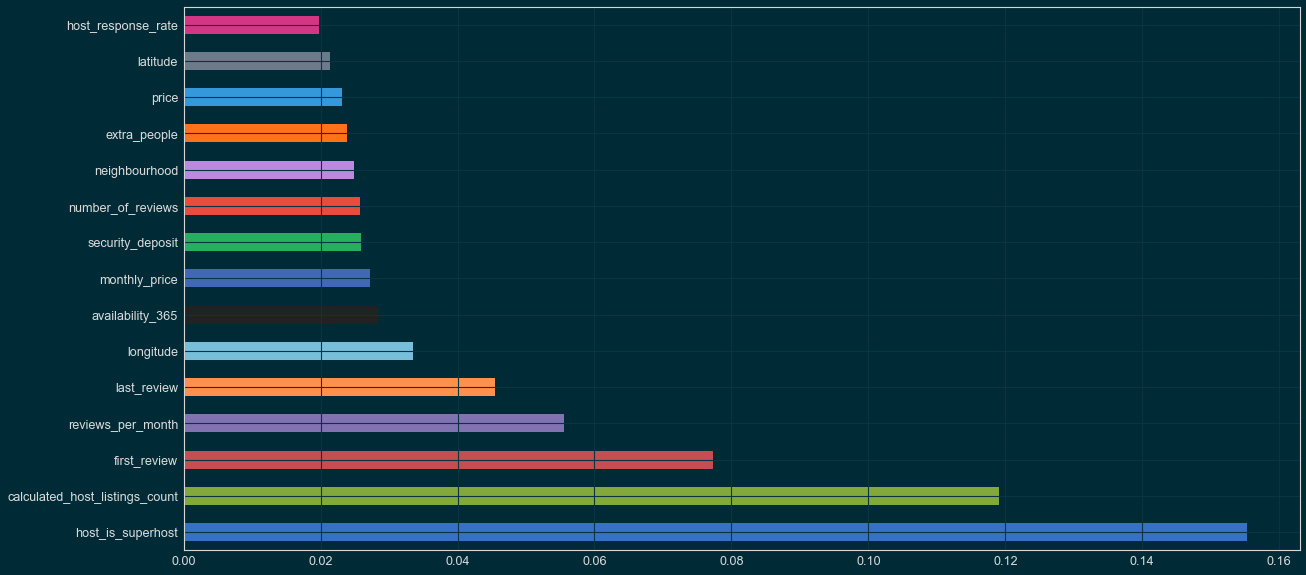

In [77]:
importances = pd.Series(model.feature_importances_, index=X.columns)
importances.sort_values(ascending=False)[:15].plot('barh')

Clearly, the most important features have to do with the host being a superhost, and the amount of listings the host have. The features related to the reviews are not very informing. The other very important features have to do with the location, availability and price. Nothing unexpected there.

Let's see how the amount of listings that the host has affects the ratings

In [71]:
def show_polyfit(x, y, pos=(5, 82)):
    a, b = np.polyfit(x, y, deg=1)
    xx = np.linspace(x.min(), x.max(), 100)
    print('a = {}, b = {}'.format(a, b))
    plt.plot(xx, a*xx + b, 'r')
    plt.text(pos[0], pos[1], 'Slope = {}'.format(a), size=30)

a = -0.21758864587459248, b = 95.55884783607411


Text(0,0.5,'Overall Rating')

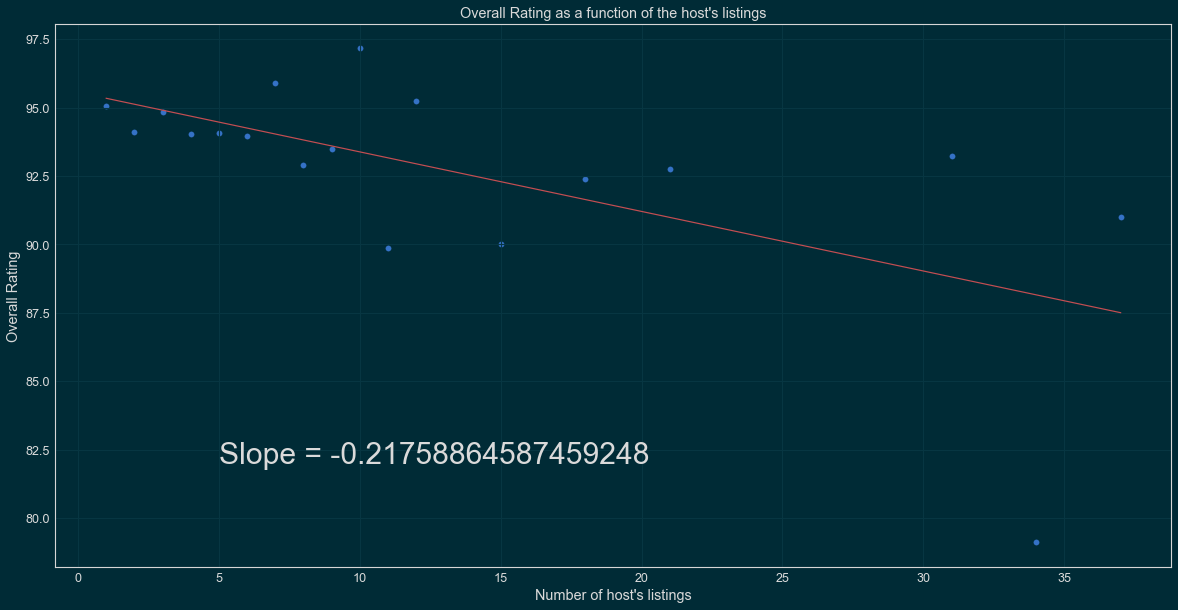

In [76]:
xy = pd.concat(
    [X.calculated_host_listings_count, y], axis=1).sort_values(
    by='calculated_host_listings_count')
xy = xy.groupby('calculated_host_listings_count').mean().reset_index()
plt.scatter(xy.calculated_host_listings_count, xy.review_scores_rating)
show_polyfit(xy.calculated_host_listings_count, xy.review_scores_rating)
_ = plt.title('Overall Rating as a function of the host\'s listings')
plt.xlabel('Number of host\'s listings')
plt.ylabel('Overall Rating')